In [48]:
from jbfg.pandas_utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

In [49]:
schema = 'l2_kjbk_extnl'

<h1>0. 데이터 세트별 데이터프레임 생성하기</h1>

In [87]:
# 6가지 데이터 세트 테이블 읽어오기
products_info = get_df('select * from products_info', schema)
train_x_past = get_df('select * from train_x_past', schema)
train_x_current = get_df('select * from train_x_current', schema)
train_y = get_df('select * from train_y', schema)
test_x_past = get_df('select * from test_x_past', schema)
test_x_current = get_df('select * from test_x_current', schema)

In [88]:
# 원본 데이터 보존을 위한 copy 생성
products_info_copy = products_info.copy()
train_x_past_copy = train_x_past.copy()
train_x_current_copy = train_x_current.copy()

In [52]:
products_info

,product_id,name,category_id,division_id,category_name,division_name
0,21709,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
2,33000,Pure Irish Butter,36,16,butter,dairy eggs
3,7781,Organic Sticks Low Moisture Part Skim Mozzarel...,21,16,packaged cheese,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
...,...,...,...,...,...,...
95,47209,Organic Hass Avocado,24,4,fresh fruits,produce
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
97,21137,Organic Strawberries,24,4,fresh fruits,produce
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce


In [53]:
products_info_copy.shape

(100, 6)

<h1>1. 데이터 탐색(EDA)</h1>

In [54]:
# product_id, name 중복 없음
products_info_copy.nunique()

product_id       100
name             100
category_id       21
division_id        9
category_name     21
division_name      9
dtype: int64

In [55]:
train_x_past_copy.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210


In [70]:
train_x_past_copy.dtypes

order_id          object
cstno             object
order_number      object
week_day          object
order_hour        object
order_interval    object
add_order         object
is_reordered      object
product_id        object
dtype: object

<h4>object 타입으로 되어있는 데이터 형식을 분석하기 편하게 int 타입으로 형변환</h4>

In [89]:
train_x_past_copy.order_number = train_x_past.order_number.astype(int)
train_x_past_copy.week_day     = train_x_past_copy.week_day.astype(int)
train_x_past_copy.order_hour   = train_x_past_copy.order_hour.astype(int)
# train_x_past_copy.order_interval = train_x_past_copy.order_interval.a
train_x_past_copy.add_order      = train_x_past_copy.add_order.astype(int)
train_x_past_copy.is_reordered   = train_x_past_copy.is_reordered.astype(int)

In [79]:
# 형변환
train_x_past_copy.dtypes

order_id          object
cstno             object
order_number       int64
week_day           int64
order_hour         int64
order_interval    object
add_order          int64
is_reordered       int64
product_id        object
dtype: object

<h4>order_interval은 숫자가 아닌 데이터 존재, 다른 방법으로 형변환</h4>

In [14]:
train_x_past_copy.order_interval = train_x_past_copy.order_interval.astype(int)

ValueError: invalid literal for int() with base 10: '3.0'

In [59]:
np.unique(train_x_past_copy['order_interval'])

array(['', '0.0', '1.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0',
       '16.0', '17.0', '18.0', '19.0', '2.0', '20.0', '21.0', '22.0',
       '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '3.0',
       '30.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0'], dtype=object)

In [60]:
train_x_past_copy[train_x_past_copy['order_interval'] == ''].head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,,10,0,24184
112,1175721,196613,1,6,13,,5,0,17794
185,1175721,196613,1,6,13,,8,0,24852
223,2057033,32775,1,0,16,,2,0,38689
258,2057033,32775,1,0,16,,4,0,34358
393,2057033,32775,1,0,16,,6,0,21137
403,2057033,32775,1,0,16,,8,0,24852
452,1783125,32780,1,5,10,,3,0,8518
630,803135,131089,1,0,11,,1,0,21903
658,803135,131089,1,0,11,,4,0,13176


In [61]:
train_x_past_copy[train_x_past_copy['order_number'] == 1].duplicated()

57         False
112        False
185        False
223        False
258        False
           ...  
1253740    False
1253837    False
1253861    False
1253910    False
1253960    False
Length: 21686, dtype: bool

In [90]:
train_x_past_copy['order_interval'] = train_x_past_copy['order_interval'].str.replace('.0','')

In [91]:
np.unique(train_x_past_copy['order_interval'])

array(['', '0', '1', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3',
       '4', '5', '6', '7', '8', '9'], dtype=object)

<p>order_number가 1인 데이터는 order_interval 값이 '' 로 들어가 있음.</p>
<p>최초 주문 건들로 해당 데이터는 -1로 넣기</p>

In [92]:
train_x_past_copy.loc[train_x_past_copy['order_interval'] == '', 'order_interval'] = '-1'

In [63]:
train_x_past_copy[train_x_past_copy['order_interval'] == -1].head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,-1,10,0,24184
112,1175721,196613,1,6,13,-1,5,0,17794
185,1175721,196613,1,6,13,-1,8,0,24852
223,2057033,32775,1,0,16,-1,2,0,38689
258,2057033,32775,1,0,16,-1,4,0,34358
393,2057033,32775,1,0,16,-1,6,0,21137
403,2057033,32775,1,0,16,-1,8,0,24852
452,1783125,32780,1,5,10,-1,3,0,8518
630,803135,131089,1,0,11,-1,1,0,21903
658,803135,131089,1,0,11,-1,4,0,13176


In [93]:
np.unique(train_x_past_copy['order_interval'])

array(['-1', '0', '1', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [97]:
train_x_past_copy.order_interval   = train_x_past_copy.order_interval.astype(int)

In [98]:
train_x_past_copy.dtypes

order_id          object
cstno             object
order_number       int64
week_day           int64
order_hour         int64
order_interval     int64
add_order          int64
is_reordered       int64
product_id        object
dtype: object

In [116]:
# train_x_current 형변환
train_x_current_copy.order_number = train_x_current_copy.order_number.astype(int)
train_x_current_copy.week_day     = train_x_current_copy.week_day.astype(int)
train_x_current_copy.order_hour   = train_x_current_copy.order_hour.astype(int)
train_x_current_copy.add_order      = train_x_current_copy.add_order.astype(int)
train_x_current_copy.is_reordered   = train_x_current_copy.is_reordered.astype(int)
train_x_current_copy['order_interval'] = train_x_current_copy['order_interval'].str.replace('.0','')
train_x_current_copy.loc[train_x_current_copy['order_interval'] == '', 'order_interval'] = '-1'
train_x_current_copy.order_interval   = train_x_current_copy.order_interval.astype(int)

In [117]:
train_x_current_copy.dtypes

order_id          object
cstno             object
order_number       int64
week_day           int64
order_hour         int64
order_interval     int64
add_order          int64
is_reordered       int64
dtype: object

<h4>데이터 형변환은 마무리했으니 주문, 고객별 특성 확인하기</h4>

In [109]:
train_x_past_copy.groupby('cstno').head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3,5,0,41220
1,2325772,196613,35,6,11,2,7,1,41220
2,642668,196613,69,2,16,2,11,1,4210
3,1326515,196613,61,3,19,3,3,1,4210
4,1437845,196613,36,3,15,4,16,0,4210
...,...,...,...,...,...,...,...,...,...
1253775,1218210,163819,13,1,11,6,17,0,43122
1253776,1478972,163819,14,1,10,7,9,1,43122
1253777,1525654,163819,15,1,11,7,2,1,43122
1253778,2103791,163819,23,1,12,7,18,0,28199


In [112]:
train_x_past_copy[train_x_past_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,-1,10,0,24184
185,1175721,196613,1,6,13,-1,8,0,24852
112,1175721,196613,1,6,13,-1,5,0,17794
101,388865,196613,2,6,14,0,7,0,31717
51,388865,196613,2,6,14,0,5,0,46667
...,...,...,...,...,...,...,...,...,...
118,185079,196613,94,6,17,6,6,0,37646
173,185079,196613,94,6,17,6,3,1,24852
5,185079,196613,94,6,17,6,1,1,38689
135,564940,196613,97,6,15,5,1,1,27966


In [118]:
train_x_current_copy[train_x_current_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
1632,2414402,196613,100,6,13,5,4,1
24170,2414402,196613,100,6,13,5,1,1


In [125]:
# 고객ID 별로 고객별주문서 순번이 연속적이지 않은 값을 가짐(누락이 있는듯)
train_x_past_copy.groupby('cstno')['order_number'].max() == train_x_past_copy.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901      True
Name: order_number, Length: 5859, dtype: bool

In [129]:
train_x_past_copy[train_x_past_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,-1,10,0,24184
185,1175721,196613,1,6,13,-1,8,0,24852
112,1175721,196613,1,6,13,-1,5,0,17794
101,388865,196613,2,6,14,0,7,0,31717
51,388865,196613,2,6,14,0,5,0,46667
...,...,...,...,...,...,...,...,...,...
118,185079,196613,94,6,17,6,6,0,37646
173,185079,196613,94,6,17,6,3,1,24852
5,185079,196613,94,6,17,6,1,1,38689
135,564940,196613,97,6,15,5,1,1,27966


In [130]:
train_196613_test = train_x_past_copy[train_x_past_copy['cstno'] == '196613']

In [131]:
train_196613_test

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3,5,0,41220
1,2325772,196613,35,6,11,2,7,1,41220
2,642668,196613,69,2,16,2,11,1,4210
3,1326515,196613,61,3,19,3,3,1,4210
4,1437845,196613,36,3,15,4,16,0,4210
...,...,...,...,...,...,...,...,...,...
198,2919366,196613,89,4,10,3,2,1,24852
199,2948577,196613,25,5,18,7,5,1,24852
200,2978591,196613,82,6,17,0,17,1,24852
201,3193705,196613,55,3,17,0,12,1,24852


In [144]:
# mean_order : 상품별 직전구매 후 경과일수의 평균값
train_x_past_copy['mean_order'] = train_x_past_copy.groupby(['product_id'])['order_interval'].transform('mean')

In [149]:
train_x_past_copy.groupby('cstno').head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order
0,717029,196613,15,1,9,3,5,0,41220,5.369009
1,2325772,196613,35,6,11,2,7,1,41220,5.369009
2,642668,196613,69,2,16,2,11,1,4210,4.819965
3,1326515,196613,61,3,19,3,3,1,4210,4.819965
4,1437845,196613,36,3,15,4,16,0,4210,4.819965
...,...,...,...,...,...,...,...,...,...,...
1253775,1218210,163819,13,1,11,6,17,0,43122,5.286890
1253776,1478972,163819,14,1,10,7,9,1,43122,5.286890
1253777,1525654,163819,15,1,11,7,2,1,43122,5.286890
1253778,2103791,163819,23,1,12,7,18,0,28199,5.206914


In [143]:
# 상품별 직전구매 후 경과일수의 평균값이 맞는지 확인
np.mean(train_x_past_copy[train_x_past_copy['product_id'] == '41220']['order_interval'])

5.369009314140559

In [ ]:
# mean_order : 상품별 직전구매 후 경과일수의 평균값
train_x_past_copy['cstno_order_count'] = train_x_past_copy.groupby(['cstno'])['order_interval'].transform('mean')

<h4>상품, 분류, 담당부서별로 주문수 확인</h4>

In [150]:
product_orders = pd.merge(train_x_past_copy, products_info, on = 'product_id', how = 'left')

In [151]:
product_orders.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3,5,0,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2,7,1,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2,11,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs
3,1326515,196613,61,3,19,3,3,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs
4,1437845,196613,36,3,15,4,16,0,4210,4.819965,Whole Milk,84,16,milk,dairy eggs
5,185079,196613,94,6,17,6,1,1,38689,5.450605,Organic Reduced Fat Milk,84,16,milk,dairy eggs
6,358293,196613,93,0,11,4,1,1,38689,5.450605,Organic Reduced Fat Milk,84,16,milk,dairy eggs
7,539821,196613,50,6,15,4,13,1,38689,5.450605,Organic Reduced Fat Milk,84,16,milk,dairy eggs
8,642668,196613,69,2,16,2,15,1,38689,5.450605,Organic Reduced Fat Milk,84,16,milk,dairy eggs
9,696513,196613,66,3,21,0,2,1,38689,5.450605,Organic Reduced Fat Milk,84,16,milk,dairy eggs


In [170]:
pivot_name = pd.pivot_table(product_orders, index = ['division_name', 'category_name','name'] , aggfunc = 'count', values = 'order_number').sort_values('order_number', ascending = False)

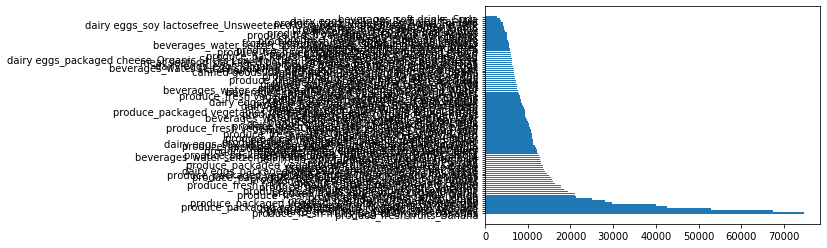

In [171]:
plt.barh([i[0]+'_'+i[1]+'_'+i[2] for i in pivot_name.index], pivot_name['order_number'].values)
plt.show()
# 으악 이게 뭐람.. 상품종류별로 보기엔 너무 많다..

In [165]:
pivot_category = pd.pivot_table(product_orders, index = ['division_name', 'category_name'] , aggfunc = 'count', values = 'order_number').sort_values('order_number', ascending = False)

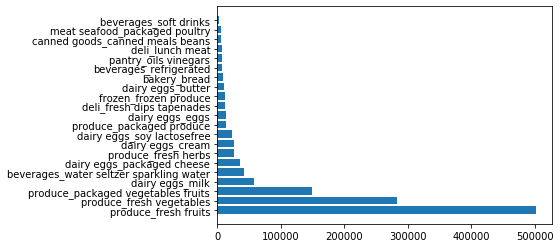

In [166]:
plt.barh([i[0]+'_'+i[1] for i in pivot_category.index], pivot_category['order_number'].values)
plt.show()

In [164]:
pd.pivot_table(product_orders, index = ['division_name'] , aggfunc = 'count', values = 'order_number').sort_values('order_number', ascending = False)

,order_number
division_name,
produce,975005
dairy eggs,166335
beverages,52044
deli,19586
frozen,11506
bakery,9083
pantry,7436
canned goods,6692
meat seafood,6285


In [175]:
pd.pivot_table(product_orders, index = ['name'] , aggfunc = 'count', values = 'order_number').sort_values('order_number', ascending = False)

,order_number
name,
Banana,74686
Bag of Organic Bananas,67514
Organic Strawberries,52917
Organic Hass Avocado,42604
Organic Baby Spinach,40112
...,...
Garlic,4210
Unsweetened Original Almond Breeze Almond Milk,4122
Roma Tomato,3829


In [174]:
product_orders

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order,name,category_id,division_id,category_name,division_name,product_order
0,717029,196613,15,1,9,3,5,0,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN
1,2325772,196613,35,6,11,2,7,1,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN
2,642668,196613,69,2,16,2,11,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN
3,1326515,196613,61,3,19,3,3,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN
4,1437845,196613,36,3,15,4,16,0,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13,2,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN
1253968,1969590,163819,42,1,15,6,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN
1253969,2549215,163819,9,1,11,7,1,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN
1253970,3103211,163819,39,1,14,7,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN


In [181]:
# mean_order : 상품별 직전구매 후 경과일수의 평균값
product_orders['product_order_count'] = product_orders.groupby(['product_id'])['order_number'].transform('count')

In [184]:
product_orders

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order,name,category_id,division_id,category_name,division_name,product_order,product_order_count
0,717029,196613,15,1,9,3,5,0,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905
1,2325772,196613,35,6,11,2,7,1,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905
2,642668,196613,69,2,16,2,11,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149
3,1326515,196613,61,3,19,3,3,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149
4,1437845,196613,36,3,15,4,16,0,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13,2,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686
1253968,1969590,163819,42,1,15,6,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686
1253969,2549215,163819,9,1,11,7,1,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686
1253970,3103211,163819,39,1,14,7,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686


In [186]:
product_orders.groupby(['product_id'])['order_number'].transform('count')

0           5905
1           5905
2           5149
3           5149
4           5149
           ...  
1253967    74686
1253968    74686
1253969    74686
1253970    74686
1253971    74686
Name: order_number, Length: 1253972, dtype: int64

In [187]:
pd.DataFrame(product_orders.groupby('week_day').order_id.nunique().sort_values(ascending=False))

,order_id
week_day,
1,60072
0,56711
5,47830
2,46057
4,44489
3,44448
6,42071


<h4>월요일에 주문이 가장 많고, 토요일에 가장 주문이 적구나!</h4>

In [188]:
df_monday = product_orders.loc[product_orders.week_day == 1]

In [213]:
! pip3 install mlxtend
#from mlxtend.preprocessing import TransactionEncoder
#from mlxtend.frequent_patterns import apriori, association_rules

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement mlxtend (from versions: none)
ERROR: No matching distribution found for mlxtend


In [200]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

ModuleNotFoundError: No module named 'mlxtend'

In [204]:
df_monday_department = pd.DataFrame(df_monday.groupby('order_id').division_name.agg(lambda x:x.tolist())).reset_index()
df_monday_department.head()

,order_id,division_name
0,1000028,"[dairy eggs, beverages, beverages, dairy eggs,..."
1,1000035,"[produce, produce]"
2,1000069,[dairy eggs]
3,1000121,"[produce, produce, produce, produce, produce]"
4,1000131,"[produce, produce, produce, produce]"


In [ ]:
# 예를들어 order_id 1000028번의 주문내역 상품의 담당부서별로 나열한 것이다.

In [205]:
te = TransactionEncoder()
te_result = te.fit(df_monday_department.division).transform(df_monday_department.division)
df_monday_department3 = pd.DataFrame(te_result, columns = te.columns_)
df_monday_department3.head()

NameError: name 'TransactionEncoder' is not defined

In [ ]:
itemset = apriori(df_monday_department3, use_colnames = Rure, min_support = 0.03)
# support지지도 0.03이상 나오는 규칙들을 itemset으로 담고
# 이것을 association_rules 함수로 실행하면 선행, 후행 규칙에 따라 지지도, 신뢰도, 향상도를 확인할 수 있다.

In [ ]:
df_monday_department4 = association_rules(itemset, metric="confidence", min_threshold = 0.85)
df_monday_department4

In [ ]:
## df_monday_department4.loc[df_monday_department4.antecedents == frozenset({#베이비?})].sort_values('#열이름? lift', ascending=False).reset_index().consequents[0]
##out : frozenset({'# 걔ㅖ란?'})

<h3>데이터 셋 분할</h3>
<h4>cstno별로 마지막 구매 번호를 nunique 함수를 통해 신규변수로 만들고 join</h4>
<h4>numpy where 함수를 통해 각 행별 order_number 변수와 order_count(신규)의 일치성을 따져 'Y'인지 'N'인지 도출하는 합성변수 ('check') 만들기</h4>

In [253]:
df_monday_order = pd.DataFrame(product_orders.groupby('cstno').order_id.nunique()).reset_index().rename(columns={'order_id':'order_count'})
df_monday_order_2 = pd.merge(product_orders, df_monday_order, how='left', on='cstno')
df_monday_order_2['check'] = np.where(df_monday_order_2['order_number'] == df_monday_order_2['order_count'], 'Y','N')
df_monday_order_2

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order,name,category_id,division_id,category_name,division_name,product_order,product_order_count,order_count,check
0,717029,196613,15,1,9,3,5,0,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905,70,N
1,2325772,196613,35,6,11,2,7,1,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905,70,N
2,642668,196613,69,2,16,2,11,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
3,1326515,196613,61,3,19,3,3,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
4,1437845,196613,36,3,15,4,16,0,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13,2,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,Y
1253968,1969590,163819,42,1,15,6,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N
1253969,2549215,163819,9,1,11,7,1,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N
1253970,3103211,163819,39,1,14,7,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N


In [254]:
df_monday_order_2_train = df_monday_order_2.loc[df_monday_order_2['check'] == 'N']
df_monday_order_2_test = df_monday_order_2.loc[df_monday_order_2['check'] == 'Y']
print(df_monday_order_2_train.shape, df_monday_order_2_test.shape)

(1231698, 19) (22274, 19)


In [ ]:
# check 변수에 따라 트레인셋 1,231,698행, 테스트셋 22,274행으로 나옴
# 트레인셋에 product_id별로 재구매여부에 따른 재구매율 확인.

In [255]:
# 판다스 crosstab 함수 이용한 후 합성변수를 만들어 product_id별 재구매율을 rate변수로 추가.
df_monday_order_2_reorder = pd.crosstab(df_monday_order_2_train['product_id'], df_monday_order_2_train['is_reordered']).reset_index()
df_monday_order_2_reorder.columns = ['product_id','no','yes']
df_monday_order_2_reorder['rate'] = df_monday_order_2_reorder['yes'] / (df_monday_order_2_reorder['yes']+df_monday_order_2_reorder['no'])
df_monday_order_2_reorder.head()

,product_id,no,yes,rate
0,10749,2017,9022,0.817284
1,11520,698,6083,0.897065
2,12341,799,6285,0.887211
3,13176,3893,62334,0.941217
4,15290,1149,3878,0.771434


In [ ]:
# 위의 재구매율을 트레인셋,테스트셋에 각각 조인함.
# 테스트셋의 경우 rate가 결측치로 나오는 값는 fillna 통해 0으로 변환.

In [256]:
df_monday_order_2_train = pd.merge(df_monday_order_2_train,df_monday_order_2_reorder[['product_id','rate']], how ='left', on = 'product_id')[['week_day','order_hour','order_interval','rate','is_reordered']]
df_monday_order_2_train

df_monday_order_2_test = pd.merge(df_monday_order_2_test,df_monday_order_2_reorder[['product_id','rate']], how ='left', on = 'product_id')[['week_day','order_hour','order_interval','rate','is_reordered']]
df_monday_order_2_test['rate'] = df_monday_order_2_test.rate.fillna(0)
df_monday_order_2_test

,week_day,order_hour,order_interval,rate,is_reordered
0,6,7,7,0.793229,1
1,6,7,7,0.810164,0
2,6,7,7,0.817284,1
3,6,7,7,0.781212,1
4,6,7,7,0.765902,1
...,...,...,...,...,...
22269,0,19,13,0.817284,0
22270,0,19,13,0.881437,1
22271,0,19,13,0.904503,1
22272,0,19,13,0.879195,1


In [261]:
# 재구매율을 트레인셋, 테스트셋에 join.
from sklearn import tree
basket_tree = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth = 6, max_leaf_nodes=25, random_state=13)
basket_tree.fit(df_monday_order_2_train.drop('order_interval', axis=1), df_monday_order_2_train['order_interval'])

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=25, random_state=13)

In [265]:
df_monday_order_2_test

,week_day,order_hour,order_interval,rate,is_reordered
0,6,7,7,0.793229,1
1,6,7,7,0.810164,0
2,6,7,7,0.817284,1
3,6,7,7,0.781212,1
4,6,7,7,0.765902,1
...,...,...,...,...,...
22269,0,19,13,0.817284,0
22270,0,19,13,0.881437,1
22271,0,19,13,0.904503,1
22272,0,19,13,0.879195,1


In [260]:
df_monday_order_2_train['predic'] = basket_tree.predict(df_monday_order_2_test.drop('order_interval', axis=1))
df_monday_order_2_train

ValueError: Length of values (22274) does not match length of index (1231698)

In [ ]:
from sklearn.metrics import recall_score

In [266]:
library(xgboost)

NameError: name 'library' is not defined

In [273]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [295]:
train_x_past_copy

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order
0,717029,196613,15,1,9,3,5,0,41220,5.369009
1,2325772,196613,35,6,11,2,7,1,41220,5.369009
2,642668,196613,69,2,16,2,11,1,4210,4.819965
3,1326515,196613,61,3,19,3,3,1,4210,4.819965
4,1437845,196613,36,3,15,4,16,0,4210,4.819965
...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13,2,1,24852,5.300860
1253968,1969590,163819,42,1,15,6,3,1,24852,5.300860
1253969,2549215,163819,9,1,11,7,1,1,24852,5.300860
1253970,3103211,163819,39,1,14,7,3,1,24852,5.300860


In [274]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [275]:
evals = [(X_test, y_test)]
clf = XGBClassifier(max_depth=10, gamma=0.001, early_stopping_rounds=20, eval_set=evals)
clf.fit(X_train, y_train)
print(clf.predict(X_test))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:32] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:21:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0]


In [276]:
print(clf.score(X_test, y_test))

0.9


In [277]:
clf.feature_importances_

array([0.08759072, 0.03269622, 0.02632424, 0.5691842 , 0.05673414,
       0.0023961 , 0.0059755 , 0.02343477, 0.03252741, 0.0162449 ,
       0.02131771, 0.01672997, 0.        , 0.0203007 , 0.        ,
       0.03191476, 0.0084612 , 0.00498234, 0.0175847 , 0.02560036],
      dtype=float32)

In [281]:
train_x_past_copy.columns

Index(['order_id', 'cstno', 'order_number', 'week_day', 'order_hour',
       'order_interval', 'add_order', 'is_reordered', 'product_id',
       'mean_order', 'name', 'category_id', 'division_id', 'category_name',
       'division_name', 'product_order', 'product_order_count', 'order_count',
       'check'],
      dtype='object')

In [294]:
df_monday_order_2

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,mean_order,name,category_id,division_id,category_name,division_name,product_order,product_order_count,order_count,check
0,717029,196613,15,1,9,3,5,0,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905,70,N
1,2325772,196613,35,6,11,2,7,1,41220,5.369009,Organic Romaine Lettuce,83,4,fresh vegetables,produce,NaN,5905,70,N
2,642668,196613,69,2,16,2,11,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
3,1326515,196613,61,3,19,3,3,1,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
4,1437845,196613,36,3,15,4,16,0,4210,4.819965,Whole Milk,84,16,milk,dairy eggs,NaN,5149,70,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13,2,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,Y
1253968,1969590,163819,42,1,15,6,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N
1253969,2549215,163819,9,1,11,7,1,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N
1253970,3103211,163819,39,1,14,7,3,1,24852,5.300860,Banana,24,4,fresh fruits,produce,NaN,74686,47,N


In [287]:
input_var = ['order_id', 'cstno', 'order_number', 'week_day', 'order_hour',
       'order_interval', 'add_order', 'is_reordered', 
       'mean_order', 'name', 'category_id', 'division_id', 'category_name',
       'division_name', 'product_order', 'product_order_count', 'order_count',
       'check']

In [289]:
xgb = XGBClassifier(n_estimatiors=300,learning_rate = 0.1)

#xgb.fit(df_monday_order_2_train[input_var], df_monday_order_2_train['product_id'])

In [ ]:
못하겠어요 ..